In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from sklearn import datasets, metrics, model_selection


In [ ]:
# non pcas

xlsx = pd.ExcelFile('./Data/Outlier_thresh1_50.xlsx')
df = pd.read_excel(xlsx, '1S 4X')
dataset1= df.copy()




from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
Sd_scaler1 =scaler1.fit(dataset1)
data1_Sd= Sd_scaler1.transform(dataset1)
print(data1_Sd)
    
    #convert to dataframe
dataset= pd.DataFrame(data1_Sd, columns=dataset1.keys())

# dropping columns
droppies= [ 'SFL' , 'NPHI', 'LLS', 'LLD']

dataset.drop(droppies, inplace=True, axis=1)

# split datat into input and target

inputs = dataset.copy()

target = inputs.pop('RHOB')


train_input, test_input, train_target, test_target = model_selection.train_test_split(inputs, target, train_size=0.7)

print('train samples:', len(train_input))
print('test samples', len(test_input))


In [3]:
xlsx = pd.ExcelFile('Feat_extracts well1.xlsx')
df = pd.read_excel(xlsx, 'PCAs')
dataset_pca= df.copy()
dataset_pca



# convert 3d to 2d
# dataset_pca.pop('PC3')

dataset_pca.pop('index')
    #convert to dataframe
# dataset_pca= pd.DataFrame(data1_Sd, columns=dataset_pca.keys())

dataset_pca

# import target column

xlsx_3 = pd.ExcelFile('Feat_extracts well1.xlsx')
df_3 = pd.read_excel(xlsx_3, 'target')
pca_target= df_3.copy()

pca_target

,RHOB
0,2.24710
1,2.25870
2,2.25890
3,2.25460
4,2.25150
...,...
13852,2.52625
13853,2.52590
13854,2.52555
13855,2.52520


In [4]:
train_input, test_input, train_target, test_target = model_selection.train_test_split(dataset_pca, pca_target['RHOB'], train_size=0.7)

print('train samples:', len(train_input))
print('test samples', len(test_input))


train samples: 9699
test samples 4158


In [ ]:
dataset

In [ ]:
dataset.shape[1]

# model

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout


model = Sequential()

model.add(Dense(64,activation="relu"
#                           , input_shape=(dataset.shape[1]-1,),
                        , input_shape=(dataset_pca.shape[1],),
                          kernel_regularizer="l2"
                         ))
    
    
#     LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

# model.add(Dense(64,activation="relu"
# #                           kernel_regularizer="l2"
#                          ))
# model.add(Dropout(0.2))


model.add(Dense(units = 1))
              

model.compile(optimizer = 'adam', loss = 'mae')

model.summary()
    

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


# train

In [17]:
%%time
tb_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/", histogram_freq=1)

model.fit(
    train_input, train_target,
    validation_split=0.3,
    verbose=0,
    batch_size = 2,
    

    #early stopping
    callbacks= keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
    
    #to store callbacks in logs
#     callbacks =[tb_callback]
)

Wall time: 8.26 s


# tunning

In [15]:
from sklearn.model_selection import GridSearchCV 
from keras.models import Sequential
from keras.layers import Dense
import warnings
warnings.filterwarnings('ignore')
from keras.wrappers.scikit_learn import KerasRegressor

# Function to create model,for KerasClassifier
def create_my_model():
    #defining my model
    mymodel = Sequential()
    mymodel.add(Dense(64, 
#                         , input_shape=(dataset.shape[1]-1,),
                        input_shape=(dataset_pca.shape[1],),
                       activation='relu'))
    mymodel.add(Dropout(0.2))
#     mymodel.add(Dense(64, input_dim=11, activation='relu'))
#     mymodel.add(Dropout(0.2))
    mymodel.add(Dense(1))
    
    # Compile the model
    mymodel.compile(loss='mae', optimizer='adam', metrics=['mse'])
    return mymodel

# create model
model_BE = KerasRegressor(build_fn=create_my_model)


# define the grid search parameters
batchSize = [2,3,4,5,7, 10, 12, 15, 20, 30, 40, 50, 60,70, 80, 90, 100]
# epochs = [5,10,15, 30, 50,70,100,150]

parameter_grid = dict(batch_size=batchSize,
#                       epochs=epochs
                     )

from sklearn.model_selection import GridSearchCV 
from keras.models import Sequential
from keras.layers import Dense
import warnings
warnings.filterwarnings('ignore')
from keras.wrappers.scikit_learn import KerasRegressor
mygrid = GridSearchCV(estimator=model_BE, param_grid=parameter_grid, n_jobs=-1, cv=3)
grid_result = mygrid.fit(train_input, train_target)


4850/4850 [==============================] - 11s 2ms/step - loss: 0.2709 - mse: 0.1900


In [16]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.075616 using {'batch_size': 2}


In [ ]:
from kerastuner.tuners import RandomSearch

def build_model(hp):
    model = keras.Sequential()

    for i in range(hp.Int('num_layers', 1, 10)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=2,
                                            max_value=64,
                                            step=2,            
#                                             sampling="log"
                                           ),
                                            activation= 'relu'
                              ))
#         for i in [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1] 
#         model.add(layers.Dropout(rate=hp.Float('D_rate_'+ str(i),
#                                               min_value=0.0,
#                                               max_value=1.0,
#                                               step=0.1
#                                                                                           ),       
#                                 ))

    model.add(layers.Dense(1,
#                            activation='linear'
                          ))
    model.compile(
        optimizer='adam',
#         keras.optimizers.Adam
#         (
#         hp.Choice('learning_rate', [0.15, 0.1, 1e-2, 1e-3, 1e-4])),
        loss='mae',
        metrics=['mse'])
    return model


tuner = RandomSearch(
    build_model,
    objective=  'val_loss',   #   'val_mean_absolute_error', #(['loss', 'mse', 'val_loss', 'val_mse']
    max_trials=10,
    executions_per_trial=5,
    directory='Test_weights2',
    project_name='ANNTuning2')


mygrid = GridSearchCV(estimator=model_BE, param_grid=parameter_grid, n_jobs=-1, cv=3)
grid_result = mygrid.fit(train_input, train_target)




tuner.search_space_summary()

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing


tuner.search(train_input, train_target,
#              epochs=35,
             validation_data=(test_input, test_target)
    
            
            
            )

In [ ]:
tuner.results_summary()

Text(0, 0.5, 'Predicted')

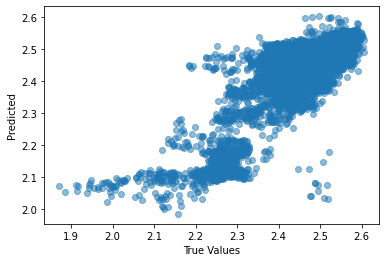

In [18]:


# predicted = myFFBP.predict(test_input) #.flatten() ##Flattening converts multidimensional lists into one-dimensional lists

predicted = model.predict(test_input)

fig, ax = plt.subplots()
ax.scatter(test_target, predicted, alpha=0.5)

ax.set_xlabel('True Values')
ax.set_ylabel('Predicted')


In [19]:
# using sklearn
print("r2 score: {}".format(metrics.r2_score(test_target,predicted)))
print("mse: {}".format(metrics.mean_squared_error(test_target, predicted)))
print("rmse: {}".format(np.sqrt(metrics.mean_squared_error(test_target, predicted))))
print("mae: {}".format(metrics.mean_absolute_error(test_target, predicted)))

r2 score: 0.49972510706078266
mse: 0.00670856109567592
rmse: 0.08190580623909345
mae: 0.06469593360190717


# Testing model on different wells

In [ ]:
# Feat_extracts well3


def predictme(wellname):
    
    xlsx = pd.ExcelFile('./Data/Outlier_thresh1_50.xlsx')
    df = pd.read_excel(xlsx, wellname)
    dataset_ext= df.copy()


    from sklearn.preprocessing import StandardScaler
    scaler1 = StandardScaler()
    Sd_scaler1 =scaler1.fit(dataset_ext)
    data1_Sd= Sd_scaler1.transform(dataset_ext)
    # print(data1_Sd)

            #convert to dataframe
    dataset= pd.DataFrame(data1_Sd, columns=dataset_ext.keys())


    # dropping columns
    dataset.drop(droppies, inplace=True, axis=1)

    print(dataset)
    # split datat into input and target

    inputs2 = dataset.copy()
    target = inputs2.pop('RHOB')


    predicted = model.predict(inputs2)

    fig, ax = plt.subplots()
    ax.scatter(target, predicted, alpha=0.5)

    ax.set_xlabel('True Values')
    ax.set_ylabel('Predicted')


    print("r2 score: {}".format(metrics.r2_score(target, predicted)))
    print("mse: {}".format(metrics.mean_squared_error(target, predicted)))
    print("rmse: {}".format(np.sqrt(metrics.mean_squared_error(target, predicted))))
    print("mae: {}".format(metrics.mean_absolute_error(target, predicted)))
    
    return 

predictme('1S 3X')
